In [1]:
from Utils.torchprojector import *
from PIL import Image
import torch
import torchvision.transforms as Trans
import numpy as np
from equilib import equi2equi, equi2pers, equi2cube, cube2equi

In [2]:
# [368, 496]

In [3]:
(496/368)*90

121.30434782608695

In [4]:
368/16

23.0

In [5]:
a1 = Image.open("/data/keshav/360/finalEgok360/data/Driving/Driving/train/frames/00000/0090.jpg").resize((1024,512))
a2 = Image.open("/data/keshav/360/finalEgok360/data/Driving/Driving/train/frames/00000/0091.jpg").resize((1024,512))

In [6]:
x1 = Trans.ToTensor()(a1)#[None]
x2 = Trans.ToTensor()(a2)#[None]

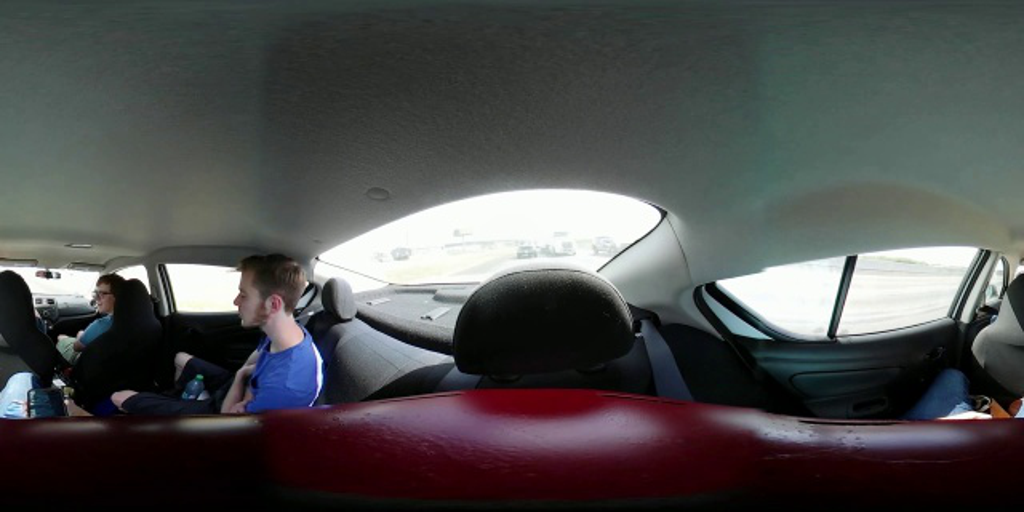

In [8]:
a1

In [9]:
# b - f
# r - r
# f - b

In [10]:
def generateInputPatch(x, resize = (368,496)):
    # expected : x.shape = 1CHW
    # output TDRLBF
    # x1 = equi2equi(x1, rots = {'pitch':0,'yaw':-np.pi/2,'roll':0})
    rots = [{'pitch':0,'yaw':-np.pi/2,'roll':np.pi/2}, 
            {'pitch':0,'yaw':-np.pi/2,'roll':-np.pi/2}, 
            {'pitch':0,'yaw':-np.pi,'roll':0},
            {'pitch':0,'yaw':0,'roll':0}, 
            {'pitch':0,'yaw':np.pi/2,'roll':0},
            {'pitch':0,'yaw':-np.pi/2,'roll':0},]
    
    eq = equi2equi(torch.cat([x]*len(rots)), rots = rots, mode = 'bicubic')
    if resize:
        return torch.nn.functional.interpolate(eq, resize)
    return eq

def gatherPatches(x, H = 256, W = 256):
    patches, _ = Te2p(x, 
                h_fov =90, 
                v_fov =90, 
                u_deg = torch.tensor([-90]), 
                v_deg = torch.tensor([0.0]), 
                in_rot_deg=torch.tensor([0]),    
                out_hw=(H,W))
    return patches

def gatherPatchToEq(j):
    T = j.select(0,0)
    D = j.select(0,1)
    R = j.select(0,2)
    L = j.select(0,3)
    B = j.select(0,4)
    F = j.select(0,5)
    data = dict(U=T,D=D,R=R,L=L,B=B,F=F)
    eq = cube2equi(data, cube_format='dict', height=512, width=1024)
    return eq

In [ ]:
Trans.ToPILImage()(X1[0][5]).resize((512,256))

In [11]:
X1 = generateInputPatch(x1[None])[None]
X2 = generateInputPatch(x2[None])[None]
# j= gatherPatches(out)
# eq = gatherPatchToEq(j)

/home/Students/k_b459/miniconda3/envs/torch11/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
# X1.shape, X2.shape

In [11]:
import math
import torch.nn.functional as F

def normalize(im):
    return im / 255.0 * 2 - 1

# source: https://discuss.pytorch.org/t/tf-extract-image-patches-in-pytorch/43837/9
def extract_image_patches(x, kernel, stride=1, dilation=1):
    # Do TF 'SAME' Padding
    b,c,h,w = x.shape
    h2 = math.ceil(h / stride)
    w2 = math.ceil(w / stride)
    pad_row = (h2 - 1) * stride + (kernel - 1) * dilation + 1 - h
    pad_col = (w2 - 1) * stride + (kernel - 1) * dilation + 1 - w
    x = F.pad(x, (pad_row//2, pad_row - pad_row//2, pad_col//2, pad_col - pad_col//2))
    
    # Extract patches
    patches = x.unfold(2, kernel, stride).unfold(3, kernel, stride)
    patches = patches.permute(0,4,5,1,2,3).contiguous()
    
    return patches.view(b,-1,patches.shape[-2], patches.shape[-1])

In [12]:
from transformers import PerceiverForOpticalFlow
import torch
from ipywidgets import FloatProgress

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = PerceiverForOpticalFlow.from_pretrained("deepmind/optical-flow-perceiver")
model.to(device)
print()

In [13]:
# model

In [14]:
X1.shape

torch.Size([1, 6, 3, 368, 496])

In [15]:
IMG = torch.stack((X1,X2),2)
IMG.shape

torch.Size([1, 6, 2, 3, 368, 496])

In [16]:
inp_piece = IMG[0][None]
inp_piece.shape

torch.Size([1, 6, 2, 3, 368, 496])

In [17]:
# Trans.ToPILImage()(inp_piece[0,0])

In [18]:
# batch_size, _, C, H, W = inp_piece.shape
# patches = extract_image_patches(inp_piece.view(batch_size*2,C,H,W), kernel=3)
# _, C, H, W = patches.shape

In [138]:
def compute_flow(model, X1, X2):
    stack = torch.stack((X1,X2),1)
    BATCH, SEQ, NPATCH, C, H, W = stack.shape
    out_stack = []
    for i in range(NPATCH):
        inp_piece = stack.select(2,i)
        patches = extract_image_patches(stack.select(2,i).view(BATCH*SEQ,C,H,W), kernel=3)
        patches = patches.view(BATCH, -1, patches.size(1), patches.size(2), patches.size(3)).float().to(model.device)
        with torch.no_grad():
            out_stack.append(model(inputs=patches).logits)
    return out_stack

In [139]:
out_stack = compute_flow(model, X1, X2)

In [434]:
from flow_vis import flow_to_color

In [435]:
out_flow = torch.cat(out_stack).cpu().detach()

In [436]:
from Utils.utils import maprange

In [437]:
out_f = out_flow.permute(0,3,1,2)

In [438]:
# x1.shape

In [439]:
B,C,H,W = out_f.shape
Ht, Wt = 512, 1024

In [440]:
hfac = Ht/H
wfac = Wt/W
hfac,wfac

(1.391304347826087, 2.064516129032258)

In [441]:
scale_flow = torch.nn.functional.interpolate(out_f, (Ht,Wt)) * torch.tensor([hfac,wfac])[None,:,None,None]

In [457]:
rmap, mflow = maprange(scale_flow)
fin_flow = gatherPatches(mflow)
# rmap, final_flow = maprange(final_flow, **rmap)

In [546]:
# rmap, fflow = maprange(final_flow, **rmap)
final_flow = gatherPatchToEq(fin_flow)
_, fflow = maprange(final_flow,**rmap)

In [549]:
# d = []
# for i in range(6):
#     fin_flow[i].permute()

In [550]:
_, finmap = maprange(fin_flow,**rmap)

In [558]:
# Image.fromarray(flow_to_color(finmap[5].permute(1,2,0).numpy()))

In [559]:
# output TDRLBF

In [566]:
tenFl = lambda x:Image.fromarray(flow_to_color(x.permute(1,2,0).numpy()))

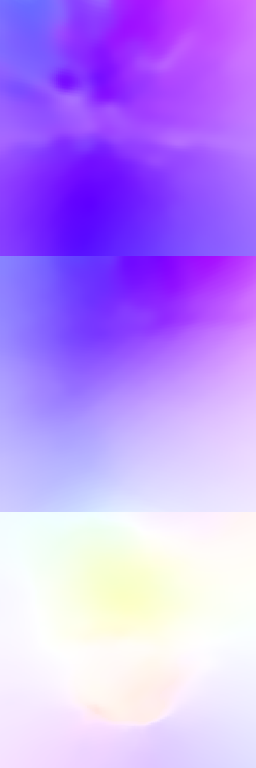

In [585]:
tenFl(torch.cat((finmap[0]/3,finmap[-1]/2,finmap[1]/4),1))

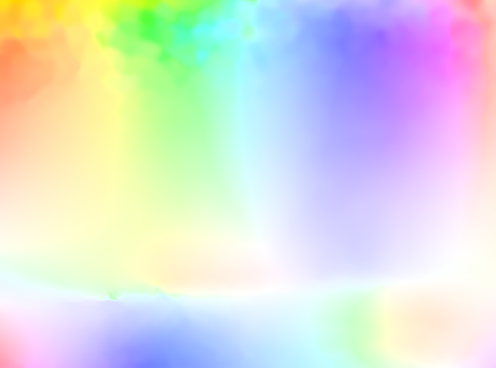

In [609]:
Image.fromarray(flow_to_color(out_stack[4][0].cpu().detach().numpy()))